# LIME

## Set-up

### Import libraries

In [1]:
!pip install -U sentence-transformers > /dev/null 2>&1
!pip install lime > /dev/null 2>&1
!pip install pyDOE2 > /dev/null 2>&1

In [2]:
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import random

import os
import glob
import copy
import joblib
import shutil
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from skimage.segmentation import mark_boundaries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sentence_transformers import SentenceTransformer

import lightgbm as lgb
from lime import lime_image, lime_text, lime_tabular

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# mount gdrive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# authenticate pydrive access to gdrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# import custom LIME explainers
os.chdir('/content/drive/My Drive/MSc Data Science/Research Project/code')

from custom_lime.custom_lime import CustomLimeImageExplainer, CustomLimeTabularExplainer, CustomLimeTextExplainer

### Set Pandas display options

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 10000)
pd.set_option('max_rows', None)
pd.set_option('max_seq_item', None)

### Check GPU is enabled

In [7]:
#check gpu is enabled
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda


### Set up working directory

In [8]:
os.chdir('/content/drive/My Drive/MSc Data Science/Research Project/data/petfinder-adoption-prediction')
!ls

breed_labels.csv   lime_explanations	      StateLabels.csv  train_final.csv
BreedLabels.csv    lime_images		      test	       train_images
color_labels.csv   PetFinder-BreedLabels.csv  test_images      train_images.zip
ColorLabels.csv    PetFinder-ColorLabels.csv  test_metadata    train_metadata
data_preprocessed  PetFinder-StateLabels.csv  test_sentiment   train_sentiment
lime_examples.csv  state_labels.csv	      train


### Set random seed

In [9]:
# Random seed function 
seed=10

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministick = True
    torch.backends.cudnn.benchmark = False 
    
set_seed(seed)

## Load data

In [10]:
# read in tabular data
data = pd.read_csv('train/train.csv')

# add name missing feature
data['Name Missing'] = data['Name'].isna()*1

# filter data for lime examples only
lime_examples = pd.read_csv('lime_examples.csv')
lime_examples['correct'] = (lime_examples['y_true'] == lime_examples['y_pred'])
data = data[data['PetID'].isin(lime_examples['PetID'].tolist())]

print('data:', data.shape)

data: (391, 25)


In [11]:
# read in image paths of lime examples
ips = pd.DataFrame(data=glob.glob('lime_images/*'),columns=['image_path'])
ips['PetID'] = ips['image_path'].apply(lambda x: x.split('-')[0].split('/')[1])

print('ips:',ips.shape)

ips: (391, 2)


In [12]:
# read in labels for categorical variables
breeds = pd.read_csv('BreedLabels.csv')
colors = pd.read_csv('ColorLabels.csv')
states = pd.read_csv('StateLabels.csv')

## Set up model

In [13]:
# set up required models/algos

# load pre-trained densenet121 model (for image feature extraction)
model_dn = models.densenet121(pretrained=True).to(device)
# remove output layer to extract embeddings
model_dn = torch.nn.Sequential(*list(model_dn.children())[:-1])
model_dn.eval()

# define transforms to convert images to tensor (ready for model)
tf_resize = transforms.Resize((224,224))
tf_totensor = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]) 

# define average pooling function
avgpool1d = torch.nn.AvgPool1d(4)

# load models text feature extraction
# tfidf = joblib.load('../../models/tfidf.pkl')
bert = SentenceTransformer('distilbert-base-nli-mean-tokens')
bert.to(device)
se_scaler = joblib.load('../../models/se_scaler.pkl')
svd = joblib.load('../../models/svd.pkl')

# load scaler objects
img_scaler = joblib.load('../../models/img_scaler.pkl')
text_scaler = joblib.load('../../models/text_scaler.pkl')
num_scaler = joblib.load('../../models/num_scaler.pkl')

# load prediction model
model_lgb = joblib.load('../../models/lgb.pkl')
# load optimal rounding thresholds
thresholds = list(joblib.load('../../models/thresholds.pkl'))

# define function to round preds based on thresholds
def round_preds(y_pred, thresholds):
    rates = np.zeros(y_pred.size, dtype=int)
    for i in range(len(thresholds)):
        rates[y_pred > thresholds[i]] = i + 1
    return rates

# text preprocessing helper functions
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

## Get data sample

In [14]:
# get random example
example = lime_examples[lime_examples['correct']==True].sample(1)
pet_id = example['PetID'].item()
y_true = example['y_true'].item()
y_pred = example['y_pred'].item()
print('pet_id:',pet_id)
print('y_pred:',y_pred)

pet_id: 182aa4a29
y_pred: 0


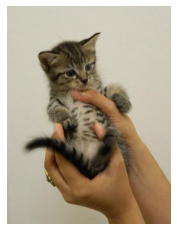

In [15]:
# get image
image = Image.open(f'lime_images/{pet_id}-1.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [16]:
# get description
desc = data[data['PetID']==pet_id]['Description'].item()
desc

"I have three kittens ready to be adopted. The mother is a half maine coon breed. Very smart and people friendly and the father is a domestic cat. One of the kitten is male,blue eyes,white fur with orange color on it's tail and at the tip of it's ears. He is very agile and naughty, likes to jump and chase ball,and always play tag with his other siblings.But he is also the most friendly when any of my family member approaches him. The other two are females. almost identical, but one of them has lighter color than the other. They both are very agile and love to be rub at their bellies. All three of them are potty trained, vaccinated, dewormed, and had treatment for lice. No adoption fees will be charged. i only hope that they all will be taken care of in your hands. You may adopt any of them or all of them. It doesnt matter. Any further info, please call me at Julie -."

In [17]:
# get tabular data
tabular = data[data['PetID']==pet_id]
tabular = tabular.drop(columns=['Name','Description','RescuerID','PetID','AdoptionSpeed'])
tabular.head(1).T

,5675
Type,2.0
Age,2.0
Breed1,265.0
Breed2,276.0
Gender,3.0
Color1,2.0
Color2,6.0
Color3,7.0
MaturitySize,3.0
FurLength,2.0


## Image LIME

### Create prediction pipeline

In [18]:
def batch_predict_image(image_data, pet_id):

    # get relevant row relating to petid
    row = data[data['PetID']==pet_id]

    # image feature extraction
    if image_data.ndim == 3:
        image_data = np.array([image_data])
    with torch.no_grad():
        out = model_dn(torch.stack(tuple(tf_totensor(i) for i in image_data), dim=0).to(device)).to(device)
    torch.cuda.empty_cache() 
    image_feats = avgpool1d(out.mean([2,3]).unsqueeze(0)).squeeze().detach().cpu().numpy()
    # rescale image features
    if image_feats.ndim > 1:
        image_feats_s = img_scaler.transform(image_feats)
    else:
        image_feats_s = img_scaler.transform(image_feats.reshape(1, -1))

    # text feature extraction
    text = [row['Description'].astype(str).item()]
    sentence_embeddings = bert.encode([text_preprocessing(t) for t in text])
    text_feats = svd.transform(se_scaler.transform(sentence_embeddings))
    # rescale text features
    text_feats_s = text_scaler.transform(text_feats)
    # duplicate text features to match number of input images
    text_feats_s = np.repeat(text_feats_s, repeats=image_feats_s.shape[0], axis=0)    

    # numeric features
    num_cols = ['Age', 'MaturitySize', 'FurLength', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']
    # rescale numeric features
    num_feats_s = num_scaler.transform(row[num_cols])
    # duplicate numeric features to match number of input images
    num_feats_s = np.repeat(num_feats_s, repeats=image_feats_s.shape[0], axis=0)

    # categorical features
    cat_cols = ['Type', 'Gender', 'Color1', 'Color2', 'Color3', 'Vaccinated', 'Dewormed', 'Sterilized',
                'Name Missing', 'Breed1', 'Breed2', 'State']
    cat_feats = row[cat_cols]
    # duplicate categorical features to match number of input images
    cat_feats = np.repeat(np.array(cat_feats), repeats=image_feats_s.shape[0], axis=0)

    # merge features
    row_p = np.concatenate((text_feats_s, image_feats_s, num_feats_s, cat_feats), axis=1)

    # run pre-processed example through model and rounding thresholds
    pred = model_lgb.predict(row_p)
    pred_r = round_preds(pred, thresholds)
    
    # turn pred into prob distr over classes
    pred_num = pred_r.shape[0]
    pred_proba = np.zeros([pred_num,4])
    for i in range(pred_num):
        pred_proba[i,pred_r[i]] = 1

    return pred_proba

In [19]:
# prediction
batch_predict_image(np.array(tf_resize(image)),pet_id)

array([[1., 0., 0., 0.]])

In [20]:
## batch prediction
batch_predict_image(np.array([np.array(tf_resize(image)),np.array(tf_resize(image))]),pet_id)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.]])

### Run LIME on image

In [21]:
explainer = CustomLimeImageExplainer()
explanation = explainer.explain_instance(np.array(tf_resize(image)), 
                                         pet_id,
                                         batch_predict_image, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=2000) # number of images that will be sent to classification function

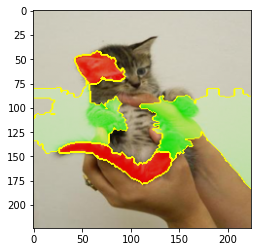

In [22]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                            num_features=6, hide_rest=False)
img_boundary1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundary1)

## Text LIME

### Create prediction pipeline

In [23]:
def batch_predict_text(text_data, pet_id):

    # using pet id, read in relevant image data
    image = Image.open(f'lime_images/{pet_id}-1.jpg')
    
    # get relevant row relating to petid
    row = data[data['PetID']==pet_id]

    # text feature extraction
    if not isinstance(text_data,list):
        text_data = [text_data]
    sentence_embeddings = bert.encode([text_preprocessing(text) for text in text_data])
    text_feats = svd.transform(se_scaler.transform(sentence_embeddings))
    # rescale text features
    text_feats_s = text_scaler.transform(text_feats)
    
    # image feature extraction
    with torch.no_grad():
        out = model_dn(tf_totensor(tf_resize(image)).unsqueeze(0).to(device)).to(device)
    torch.cuda.empty_cache() 
    image_feats = avgpool1d(out.mean([2,3]).unsqueeze(0)).squeeze().detach().cpu().numpy()
    # rescale image features
    image_feats_s = img_scaler.transform(image_feats.reshape(1, -1))
    # duplicate image features to match number of text inputs
    image_feats_s = np.repeat(image_feats_s, repeats=text_feats_s.shape[0], axis=0)

    # numeric features
    num_cols = ['Age', 'MaturitySize', 'FurLength', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']
    # rescale numeric features
    num_feats_s = num_scaler.transform(row[num_cols])
    # duplicate numeric features to match number of input images
    num_feats_s = np.repeat(num_feats_s, repeats=text_feats_s.shape[0], axis=0)

    # categorical features
    cat_cols = ['Type', 'Gender', 'Color1', 'Color2', 'Color3', 'Vaccinated', 'Dewormed', 'Sterilized',
                'Name Missing', 'Breed1', 'Breed2', 'State']
    cat_feats = row[cat_cols]
    # duplicate categorical features to match number of input images
    cat_feats = np.repeat(np.array(cat_feats), repeats=text_feats_s.shape[0], axis=0)

    # merge features
    row_p = np.concatenate((text_feats_s, image_feats_s, num_feats_s, cat_feats), axis=1)

    # run pre-processed example through model and rounding thresholds
    pred = model_lgb.predict(row_p)
    pred_r = round_preds(pred, thresholds)
    
    # turn pred into prob distr over classes
    pred_num = pred_r.shape[0]
    pred_proba = np.zeros([pred_num,4])
    for i in range(pred_num):
        pred_proba[i,pred_r[i]] = 1

    return pred_proba

In [24]:
batch_predict_text(desc,pet_id)

array([[1., 0., 0., 0.]])

In [25]:
batch_predict_text([desc,desc,desc],pet_id)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

### Run LIME on text

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


CPU times: user 34.6 s, sys: 8.96 s, total: 43.6 s
Wall time: 43.4 s


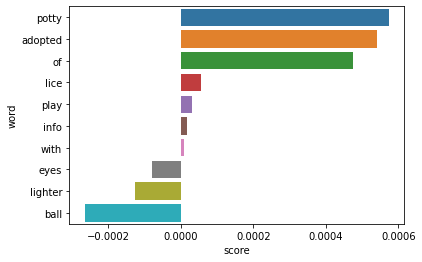

In [26]:
%%time
class_names = [0,1,2,3]
explainer = CustomLimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(desc, batch_predict_text, pet_id, num_samples=10000, 
                                 num_features=10, top_labels=1)

top_words = exp.as_list(label=exp.available_labels()[0])

df = pd.DataFrame(top_words,columns=['word','score']).sort_values('score',ascending=False)
sns.barplot(y='word',x='score',data=df)

In [27]:
# %%time
# class_names = [0,1,2,3]

# stops = [stopword.replace("'",'') for stopword in set(stopwords.words('english'))]

# num_features = len(list(set(desc.lower().split(' '))))
# explainer = CustomLimeTextExplainer(class_names=class_names)
# exp = explainer.explain_instance(desc, batch_predict_text, pet_id, num_samples=10000, 
#                                  num_features=num_features, top_labels=1)

# top_words = exp.as_list(label=exp.available_labels()[0])
# top_words = [(word.lower(),score) for (word,score) in top_words if word.lower() not in stops]

# df = pd.DataFrame(top_words,columns=['word','score'])
# df['score_abs'] = abs(df['score'])
# df = df.sort_values('score_abs',ascending=False)[:10].sort_values('score',ascending=False)

# sns.barplot(y='word',x='score',data=df)

## Tabular LIME

### Create Prediction Pipeline

In [28]:
def batch_predict_tabular(tabular_data, pet_id):

    # using pet id, read in relevant image data
    image = Image.open(f'lime_images/{pet_id}-1.jpg')
    
    # using pet id, read in relevant text data
    text = data.loc[(data['PetID']==pet_id),'Description'].item()
    
    # save data as df
    cols = ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 
            'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 
            'VideoAmt', 'PhotoAmt', 'Name Missing']
    if tabular_data.ndim > 1:
        df = pd.DataFrame(tabular_data, columns=cols)
    else:
        df = pd.DataFrame(sample.reshape(1,-1), columns=cols)
    
    # numeric features
    num_cols = ['Age', 'MaturitySize', 'FurLength', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']
    # rescale numeric features
    num_feats_s = num_scaler.transform(df[num_cols])

    # categorical features
    cat_cols = ['Type', 'Gender', 'Color1', 'Color2', 'Color3', 'Vaccinated', 'Dewormed', 'Sterilized',
                'Name Missing', 'Breed1', 'Breed2', 'State']
    cat_feats = df[cat_cols].copy()

    # image feature extraction
    with torch.no_grad():
        out = model_dn(tf_totensor(tf_resize(image)).unsqueeze(0).to(device)).to(device)
    torch.cuda.empty_cache() 
    image_feats = avgpool1d(out.mean([2,3]).unsqueeze(0)).squeeze().detach().cpu().numpy()
    # rescale image features
    image_feats_s = img_scaler.transform(image_feats.reshape(1, -1))
    # duplicate image features to match number of text inputs
    image_feats_s = np.repeat(image_feats_s, repeats=df.shape[0], axis=0)

    # text feature extraction
    text = [text]
    sentence_embeddings = bert.encode([text_preprocessing(t) for t in text])
    text_feats = svd.transform(se_scaler.transform(sentence_embeddings))
    # rescale text features
    text_feats_s = text_scaler.transform(text_feats)
    # duplicate text features to match number of input images
    text_feats_s = np.repeat(text_feats_s, repeats=image_feats_s.shape[0], axis=0)   

    # merge features
    row_p = np.concatenate((text_feats_s, image_feats_s, num_feats_s, cat_feats), axis=1)

    # run pre-processed example through model and rounding thresholds
    pred = model_lgb.predict(row_p)
    pred_r = round_preds(pred, thresholds)
    
    # turn pred into prob distr over classes
    pred_num = pred_r.shape[0]
    pred_proba = np.zeros([pred_num,4])
    for i in range(pred_num):
        pred_proba[i,pred_r[i]] = 1

    return pred_proba

In [29]:
sample = np.array(tabular).squeeze(0)
batch_predict_tabular(sample,pet_id)

array([[1., 0., 0., 0.]])

In [30]:
batch_predict_tabular(np.array([sample,sample]),pet_id)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.]])

### Run LIME on tabular data

In [37]:
# define feature names, cat features, and class names

feature_names = ['Type', 'Age (months)', 'Breed 1', 'Breed 2', 'Gender', 'Colour 1', 'Colour 2', 'Colour 3', 
                 'Maturity Size', 'Fur Length', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 
                 'Quantity', 'Fee', 'State', 'Video Amount', 'Photo Amount', 'Name Missing']

categorical_features = [0,2,3,4,5,6,7,10,11,12,16,19]

class_names = np.array(['0-7 Days','8-30 Days','31-90 Days','100+ Days'])

# create state_labels
mask = np.array(states['StateID'])
state_names = np.array(states['StateName'])
state_labels = np.array(['N/A'] * (states['StateID'].max()+1), dtype=object)
state_labels[mask] = state_names

# create categorical name map. categorical_names[x][y] is yth value name of xth column
categorical_names = {}
categorical_names[0] = np.array(['N/A','Dog','Cat'])
categorical_names[2] = np.array(['N/A'] + breeds['BreedName'].tolist())
categorical_names[3] = np.array(['N/A'] + breeds['BreedName'].tolist())
categorical_names[4] = np.array(['N/A','Male','Female','Mixed'])
categorical_names[5] = np.array(['N/A'] + colors['ColorName'].tolist())
categorical_names[6] = np.array(['N/A'] + colors['ColorName'].tolist())
categorical_names[7] = np.array(['N/A'] + colors['ColorName'].tolist())
categorical_names[10] = np.array(['N/A','Yes','No','Not Sure'])
categorical_names[11] = np.array(['N/A','Yes','No','Not Sure'])
categorical_names[12] = np.array(['N/A','Yes','No','Not Sure'])
categorical_names[16] = np.array(state_labels)
categorical_names[19] = np.array(['No', 'Yes']) 

# prep tabular sample and training data
sample = np.array(tabular).squeeze(0)

train = pd.read_csv('train_final.csv')
# add name missing feature
train['Name Missing'] = train['Name'].isna()*1
# drop columns
train = train.drop(columns=['Name','Description','RescuerID','PetID','AdoptionSpeed'])

In [32]:
explainer = CustomLimeTabularExplainer(np.array(train), feature_names = feature_names, 
                                       class_names=class_names, categorical_features=categorical_features, 
                                       categorical_names=categorical_names)
exp = explainer.explain_instance(sample, batch_predict_tabular, pet_id, num_features=10, top_labels=1)

exp.show_in_notebook(show_all=False, predict_proba=False)

In [33]:
# function to recode numerical discrete features
def recode_values(feature):
    counts=Counter(feature) 
    if 'Maturity Size' in feature:
        feature = feature.replace('1.00','Small').replace('2.00','Medium').replace('3.00','Large')\
                         .replace('4.00','Extra Large')                      
    elif 'Fur Length' in feature:
        feature = feature.replace('1.00','Short').replace('2.00','Medium').replace('3.00','Long')         
    elif 'Health' in feature:
        feature = feature.replace('1.00','Healthy').replace('2.00','Minor Injury')\
                         .replace('3.00','Serious Injury')
        if counts['=']==1 and (counts['>']==1 or counts['<']==1):
            feature = feature.replace('>','').replace('<','')
    elif 'Fee <= 0.00' in feature:
        feature = feature.replace('<=','=')
    elif 'Quantity <= 1.00' in feature:
        feature = feature.replace('<=','=')        
    return feature

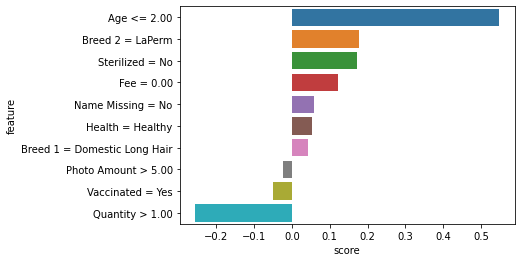

In [34]:
top_feats = exp.local_exp[exp.available_labels()[0]]
df = pd.DataFrame(top_feats,columns=['feature','score']).sort_values('score',ascending=False)
df['feature'] = df['feature'].apply(lambda x: exp.domain_mapper.discretized_feature_names[x])
df['feature'] = df['feature'].apply(recode_values)
sns.barplot(y='feature',x='score',data=df)

## Save LIME outputs

### Pick examples

In [35]:
class_names

array(['0-7 Days', '8-30 Days', '31-90 Days', '100+ Days'], dtype='<U10')

In [35]:
pet_ids = [item.split('-')[1].split('.')[0] for item in os.listdir('lime_explanations/images')]
y_preds = [int(item.split('-')[0]) for item in os.listdir('lime_explanations/images')]

y_preds = list(np.array(y_preds)[np.argsort(np.array(pet_ids))])
pet_ids = list(np.sort(np.array(pet_ids)))

In [37]:
# # pick random examples, evenly from each predicted class (true predictions)
# num_examples = 15
# examples_0 = lime_examples[((lime_examples['y_pred']==0) & (lime_examples['correct']==True))].sample(num_examples)
# examples_1 = lime_examples[((lime_examples['y_pred']==1) & (lime_examples['correct']==True))].sample(num_examples)
# examples_2 = lime_examples[((lime_examples['y_pred']==2) & (lime_examples['correct']==True))].sample(num_examples)
# examples_3 = lime_examples[((lime_examples['y_pred']==3) & (lime_examples['correct']==True))].sample(num_examples)

# examples = pd.concat([examples_0,examples_1,examples_2,examples_3],axis=0)

# # get pet ids, and preds of chosen examples
# pet_ids = examples.sort_values('PetID')['PetID'].tolist()
# y_preds = examples.sort_values('PetID')['y_pred'].tolist()

# prep examples
examples = data[data['PetID'].isin(pet_ids)].drop(columns=['Name','RescuerID','AdoptionSpeed'])
examples = examples.sort_values('PetID').set_index('PetID')
examples['Predicted Adoption Speed'] = y_preds
examples = examples.rename(columns={'Age':'Age (months)','Breed1':'Breed 1','Breed2':'Breed 2','Color1':'Colour 1',
                                    'Color2':'Colour 2','Color3':'Colour 3','MaturitySize':'Maturity Size',
                                    'FurLength':'Fur Length','VideoAmt':'Video Amount','PhotoAmt':'Photo Amount'})
examples = examples[[col for col in examples.columns if col not in ['Description','Predicted Adoption Speed']] + 
                    ['Description','Predicted Adoption Speed']]

# add descriptors to categorical feature values
for i in categorical_features:
    col_values = np.array(examples.iloc[:,i]).flatten()
    num_values = len(col_values)
    col_values_new = ['blank']*num_values
    for j in range(num_values):
        col_values_new[j] = categorical_names[i][col_values[j]]
    examples.iloc[:,i] = col_values_new

# add descriptors to discrete numerical values
dis_num_feats = [8,9,13]
dis_num_names = {}
dis_num_names[8] = np.array(['Not Specified','Small','Medium','Large','Extra Large'])
dis_num_names[9] = np.array(['Not Specified','Short','Medium','Long'])
dis_num_names[13] = np.array(['Not Specified','Healthy','Minor Injury','Serious Injury'])

for i in dis_num_feats:
    col_values = np.array(examples.iloc[:,i]).flatten()
    num_values = len(col_values)
    col_values_new = ['blank']*num_values
    for j in range(num_values):
        col_values_new[j] = dis_num_names[i][col_values[j]]
    examples.iloc[:,i] = col_values_new

# add predicted class labels in
num_values = len(y_preds)
y_preds_new = ['blank']*num_values
for j in range(num_values):
    y_preds_new[j] = class_names[y_preds[j]]
examples['Predicted Adoption Speed'] = y_preds_new

examples.shape


(80, 22)

### Images

In [ ]:
# create folder to save images relating to picked examples
if os.path.exists('lime_explanations/images'):
    files = glob.glob('lime_explanations/images/*')
    for f in files:
        os.remove(f)
else:
    os.makedirs('lime_explanations/images')

# create folder to save lime outputs
if os.path.exists('lime_explanations/lime_images'):
    files = glob.glob('lime_explanations/lime_images/*')
    for f in files:
        os.remove(f)
else:
    os.makedirs('lime_explanations/lime_images')

In [ ]:
%%time

# set up image explainer
explainer = CustomLimeImageExplainer()

for i, (pet_id, y_pred) in enumerate(zip(pet_ids,y_preds)):
    print(f'example {i+1}')
    # open image
    image = Image.open(f'lime_images/{pet_id}-1.jpg')

    # save image in dedicated folder
    img = image.resize((300,300))
    img.save(f'lime_explanations/images/{y_pred}-{pet_id}.jpg')

    # produce lime explanation for image, and save in separate folder
    explanation = explainer.explain_instance(np.array(tf_resize(image)), 
                                            pet_id,
                                            batch_predict_image, 
                                            top_labels=1, 
                                            hide_color=0, 
                                            num_samples=2000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                            num_features=5, hide_rest=False)
    img_lime = Image.fromarray((mark_boundaries(temp/255.0, mask) * 255).astype(np.uint8))
    img_lime = img_lime.resize((300,300))
    img_lime.save(f'lime_explanations/lime_images/{y_pred}-{pet_id}.jpg')

example 1



example 2



example 3



example 4



example 5



example 6



example 7



example 8



example 9



example 10



example 11



example 12



example 13



example 14



example 15



example 16



example 17



example 18



example 19



example 20



example 21



example 22



example 23



example 24



example 25



example 26



example 27



example 28



example 29



example 30



example 31



example 32



example 33



example 34



example 35



example 36



example 37



example 38



example 39



example 40



example 41



example 42



example 43



example 44



example 45



example 46



example 47



example 48



example 49



example 50



example 51



example 52



example 53



example 54



example 55



example 56



example 57



example 58



example 59



example 60



example 61



example 62



example 63



example 64



example 65



example 66



example 67



example 68



example 69



example 70



example 71



example 72



example 73



example 74



example 75



example 76



example 77



example 78



example 79



example 80



CPU times: user 31min 55s, sys: 33min 53s, total: 1h 5min 48s
Wall time: 37min 23s


In [39]:
# get gdrive image urls
# image urls
file_list = drive.ListFile({'q': "'1-fwoLWbdAg6I8e_QgbYqjkASkuikmvQz' in parents and trashed=false"}).GetList()
image_data_l = []
for img in file_list:
    image_data_d = {}
    image_data_d['PetID'] = img['title'].split('-')[1].split('.')[0]
    image_data_d['Image URL'] = 'https://drive.google.com/uc?id=' + img['id']
    image_data_l.append(image_data_d)
image_data = pd.DataFrame(image_data_l)

# lime image urls
file_list = drive.ListFile({'q': "'1-5nBGq6iiru9EBkq22yNhk55wgxJp6qx' in parents and trashed=false"}).GetList()
image_data_l = []
for img in file_list:
    image_data_d = {}
    image_data_d['PetID'] = img['title'].split('-')[1].split('.')[0]
    image_data_d['Lime Image URL'] = 'https://drive.google.com/uc?id=' + img['id']
    image_data_l.append(image_data_d)
lime_image_data = pd.DataFrame(image_data_l)

# add image urls to examples df
examples = pd.concat([examples,image_data.set_index('PetID'),lime_image_data.set_index('PetID')],axis=1)
examples = examples.reset_index().rename(columns={'index':'PetID'})

# save to csv
examples.to_csv('lime_explanations/examples.csv',index=False)

examples.shape


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

(80, 25)

### Text

In [ ]:
%%time

# set up stopwords
# stops = [stopword.replace("'",'') for stopword in set(stopwords.words('english'))]

# set up text explainer
class_names = [0,1,2,3]
explainer = CustomLimeTextExplainer(class_names=class_names)

# create df with top words and their scores for each example
df_list = []
for i, pet_id in enumerate(pet_ids):
# for i, pet_id in ([(0,'182aa4a29')]):
    print(f'example {i+1}')
    print()
    desc = data[data['PetID']==pet_id]['Description'].item()
    # num_features = len(list(set(desc.lower().split(' '))))
    exp = explainer.explain_instance(desc, batch_predict_text, pet_id, num_samples=10000, 
                                    num_features=10, top_labels=1)
    top_words = exp.as_list(label=exp.available_labels()[0])
    # top_words = [(word.lower(),score) for (word,score) in top_words if word.lower() not in stops]
    df = pd.DataFrame(top_words,columns=['word','score'])
    df['PetID'] = pet_id
    # df['score_abs'] = abs(df['score'])
    # df = df.sort_values('score_abs',ascending=False)[:10]
    df_list.append(df)

df = pd.concat(df_list,axis=0).reset_index(drop=True)
# df = df[['PetID','word','score','score_abs']]
df = df[['PetID','word','score']]

# save df
df.to_csv('lime_explanations/lime_text.csv',index=False)


example 1



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 2



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 3



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 4



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 5



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 6



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 7



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 8



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 9



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 10



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 11



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 12



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 13



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 14



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 15



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 16



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 17



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 18



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 19



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 20



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 21



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 22



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 23



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 24



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 25



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 26



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 27



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 28



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 29



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 30



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 31



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 32



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 33



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 34



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 35



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 36



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 37



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 38



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 39



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 40



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 41



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 42



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 43



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 44



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 45



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 46



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 47



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 48



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 49



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 50



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 51



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 52



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 53



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 54



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 55



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 56



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 57



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 58



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 59



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 60



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 61



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 62



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 63



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 64



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 65



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 66



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 67



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 68



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 69



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 70



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 71



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 72



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 73



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 74



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 75



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 76



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 77



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 78



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 79



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


example 80



/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


CPU times: user 24min 47s, sys: 4min 56s, total: 29min 43s
Wall time: 29min 20s


### Tabular

In [38]:
%%time
# get training data
train = pd.read_csv('train_final.csv')
# add name missing feature
train['Name Missing'] = train['Name'].isna()*1
# drop columns
train = train.drop(columns=['Name','Description','RescuerID','PetID','AdoptionSpeed'])

# set up tabular explainer
explainer = CustomLimeTabularExplainer(np.array(train), feature_names=feature_names, 
                                       class_names=class_names, categorical_features=categorical_features, 
                                       categorical_names=categorical_names)

# create df with top features, and their scores for each example
df_list = []
for i, pet_id in enumerate(pet_ids):
    print(f'example {i+1}')
    print()

    # get example
    tabular = data[data['PetID']==pet_id]
    tabular = tabular.drop(columns=['Name','Description','RescuerID','PetID','AdoptionSpeed'])
    sample = np.array(tabular).squeeze(0)

    # get top explanations
    exp = explainer.explain_instance(sample, batch_predict_tabular, pet_id, num_features=10, 
                                     num_samples=10000, top_labels=1)
    top_feats = exp.local_exp[exp.available_labels()[0]]
    df = pd.DataFrame(top_feats,columns=['feature','score']).sort_values('score',ascending=False)
    df['feature'] = df['feature'].apply(lambda x: exp.domain_mapper.discretized_feature_names[x])
    df['feature'] = df['feature'].apply(recode_values)
    df['PetID'] = pet_id
    df['score_abs'] = abs(df['score'])
    df = df.sort_values('score_abs',ascending=False)

    # append to df list
    df_list.append(df)

# concatenate into single df
df = pd.concat(df_list,axis=0).reset_index(drop=True)
df = df[['PetID','feature','score','score_abs']]

# save df
df.to_csv('lime_explanations/lime_tabular.csv',index=False)   


example 1

example 2

example 3

example 4

example 5

example 6

example 7

example 8

example 9

example 10

example 11

example 12

example 13

example 14

example 15

example 16

example 17

example 18

example 19

example 20

example 21

example 22

example 23

example 24

example 25

example 26

example 27

example 28

example 29

example 30

example 31

example 32

example 33

example 34

example 35

example 36

example 37

example 38

example 39

example 40

example 41

example 42

example 43

example 44

example 45

example 46

example 47

example 48

example 49

example 50

example 51

example 52

example 53

example 54

example 55

example 56

example 57

example 58

example 59

example 60

example 61

example 62

example 63

example 64

example 65

example 66

example 67

example 68

example 69

example 70

example 71

example 72

example 73

example 74

example 75

example 76

example 77

example 78

example 79

example 80

CPU times: user 4min 49s, sys: 21.1 s, total: 5mi